In [2]:
"""
The Resnet model was developed and trained on an ImageNet dataset as well as the CIFAR-10 dataset. As such it is
optimized for visual recognition tasks, and showed a marked improvement over the VGG series, which is why we will be using it.
"""
import os, time
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, dataloader
from torchvision import datasets, models
import scipy.io as sio
import random
import sklearn
from PIL import Image
from pathlib import Path
from torch import optim
from torchmetrics import Accuracy, Precision, F1Score


In [3]:
main_dir  = Path('C:/Users/benjamin.guerrieri/Documents/AutoSenseBackup/NoHatchbackFinalDataset')

In [4]:
from torchvision import transforms
#identifies a transformer to make all images the same size
transformer = torchvision.transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomHorizontalFlip(),
    #transforms.Grayscale()

])

In [5]:
main_folder = torchvision.datasets.ImageFolder(main_dir, transform = transformer)
main_folder

Dataset ImageFolder
    Number of datapoints: 17400
    Root location: C:\Users\benjamin.guerrieri\Documents\AutoSenseBackup\NoHatchbackFinalDataset
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [6]:
classes = main_folder.classes
classes

['Convertible', 'Coupe', 'Minivan', 'SUV', 'Sedan', 'Truck', 'Van']

torch.Size([3, 224, 224])


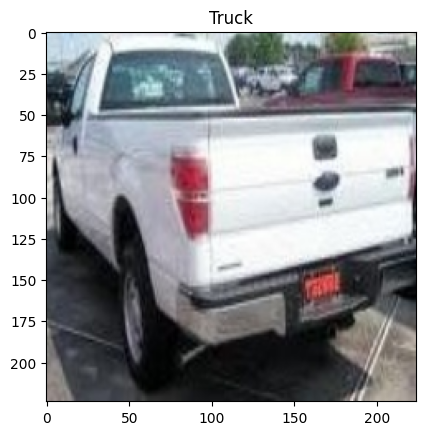

In [7]:
#grabs random image and label in the datafolder
img, label = main_folder[random.randrange(0, len(main_folder))]

import matplotlib.pyplot as plt
img_sample = img.permute(1, 2, 0)
print(img.shape)
plt.imshow(img_sample)
plt.title(classes[label]);

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cpu'

In [9]:
import torch.utils.data as data

BATCH_SIZE = 32
NUM_WORKER = 0

# Random split
train_set_size = int(len(main_folder) * .8)   #80% of data for training
valid_set_size = int(len(main_folder) * .1) #10% for validation
test_set_size = int(len(main_folder) - train_set_size - valid_set_size) #10% for testing
train_set, valid_set, test_set = data.random_split(main_folder, [train_set_size, valid_set_size, test_set_size])

train_set_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER)  
valid_set_loader = data.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER) 
test_set_loader  = data.DataLoader(test_set , batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKER)
dataloaders = {'train': train_set_loader, 'val': valid_set_loader, 'test': test_set_loader}

"""
Training Set: this data set is used to adjust the weights on the neural network.

Validation Set: this data set is used to minimize overfitting. You're not adjusting the weights of the network with this data set, you're just 
verifying that any increase in accuracy over the training data set actually yields an increase in accuracy over a data set that has not been 
shown to the network before, or at least the network hasn't trained on it (i.e. validation data set). If the accuracy over the training data set increases, 
but the accuracy over the validation data set stays the same or decreases, then you're overfitting your neural network and you should stop training.

Testing Set: this data set is used only for testing the final solution in order to confirm the actual predictive power of the network.
"""


"\nTraining Set: this data set is used to adjust the weights on the neural network.\n\nValidation Set: this data set is used to minimize overfitting. You're not adjusting the weights of the network with this data set, you're just \nverifying that any increase in accuracy over the training data set actually yields an increase in accuracy over a data set that has not been \nshown to the network before, or at least the network hasn't trained on it (i.e. validation data set). If the accuracy over the training data set increases, \nbut the accuracy over the validation data set stays the same or decreases, then you're overfitting your neural network and you should stop training.\n\nTesting Set: this data set is used only for testing the final solution in order to confirm the actual predictive power of the network.\n"

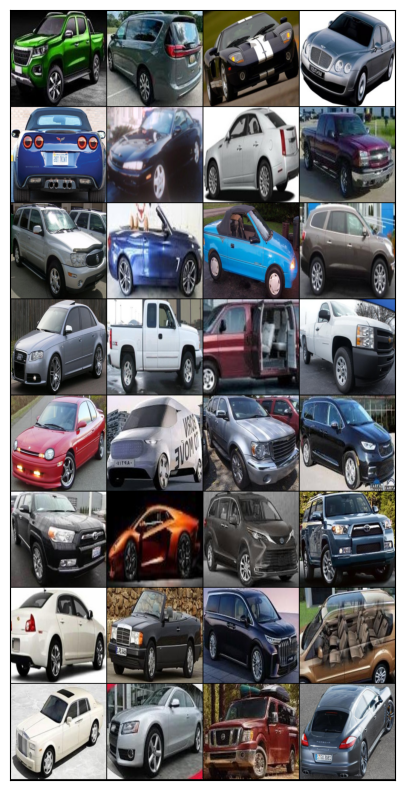

In [10]:
# Visualize one training batch
from torchvision.utils import make_grid
for images, labels in train_set_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

In [11]:
res_mod = models.resnet34(pretrained=True)

num_ftrs = res_mod.fc.in_features
res_mod.fc = nn.Linear(num_ftrs, len(classes))

c:\Users\benjamin.guerrieri\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\benjamin.guerrieri\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
res_mod

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
LEARNING_RATE = .001 #.0005 #b.001680

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(res_mod.parameters(), lr=LEARNING_RATE)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


In [14]:
epochs = 40
valid_loss_min = np.Inf
train_losses, valid_losses = [], []
history_accuracy = []

for e in range(1, epochs+1):
    running_loss = 0

    for images, labels in train_set_loader:
        # if train_on_gpu:
        #     images, labels = images.cuda(), labels.cuda()

        # Clear the gradients, do this because gradients are accumulated.
        optimizer.zero_grad()
        
        # Forward pass, get our log-probabilities.
        ps = res_mod(images)

        # Calculate the loss with the logps and the labels.
        loss = criterion(ps, labels)
        
        # Turning loss back.
        loss.backward()
        
        # Take an update step and few the new weights.
        optimizer.step()
        
        running_loss += loss.item()
        # scheduler.step()
    else:
        valid_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations.
        with torch.no_grad():
            res_mod.eval() # change the network to evaluation mode
            for images, labels in valid_set_loader:
                # if train_on_gpu:
                #     images, labels = images.cuda(), labels.cuda()

                # Forward pass, get our log-probabilities.
                #log_ps = model(images)
                ps = res_mod(images)
                
                # Calculating probabilities for each class.
                #ps = torch.exp(log_ps)
                
                # Capturing the class more likely.
                _, top_class = ps.topk(1, dim=1)
                
                # Verifying the prediction with the labels provided.
                equals = top_class == labels.view(*top_class.shape)
                
                valid_loss += criterion(ps, labels)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        res_mod.train() # change the network to training mode
        
        train_losses.append(running_loss/len(train_set_loader))
        valid_losses.append(valid_loss/len(valid_set_loader))
        history_accuracy.append(accuracy/len(valid_set_loader))
        
        network_learned = valid_loss < valid_loss_min

        if e == 1 or e % 5 == 0 or network_learned:
            print(f"Epoch: {e}/{epochs}.. ",
                  f"Training Loss: {running_loss/len(train_set_loader):.3f}.. ",
                  f"Validation Loss: {valid_loss/len(valid_set_loader):.3f}.. ",
                  f"Test Accuracy: {accuracy/len(valid_set_loader):.3f}")
        
        if network_learned:
            valid_loss_min = valid_loss
            torch.save(res_mod.state_dict(), 'car_model_TL.pt')
            print('Detected network improvement, saving current model')

KeyboardInterrupt: 

In [ ]:
# model = model()
res_mod.load_state_dict(torch.load("C:/Users/benjamin.guerrieri/Documents/AutoSenseBackup/Models/car_model_TL.pt"))
res_mod.eval()




y_pred = []
y_true = []

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_set_loader:
        images, labels = data
        # print(np.shape(images))
        # calculate outputs by running images through the network
        outputs = res_mod(images)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)

        y_pred.extend(predicted) # Save Prediction

        y_true.extend(labels) # Save Truth

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {test_set_size} unseen test images: {100 * correct // total} %')


#try training with one rgb channel 
#load model and test with image not in dataset
#live plot or just plot loss and validation loss and accuracy
#use efficient net0b w/ transfer learning
#try transfer learning
#do research into good models
#try changing kernel size in conv2d layers
#confusion matrix to find problems between classes
#pretrained model / transfer learning
#120 : 180
#visualize neural network
#show different models
#get rid of other class'
#double data with horizontal flipping
#***per-pixel mean subtracted***

#object tracking with cars 

Accuracy of the network on the 1740 unseen test images: 93 %


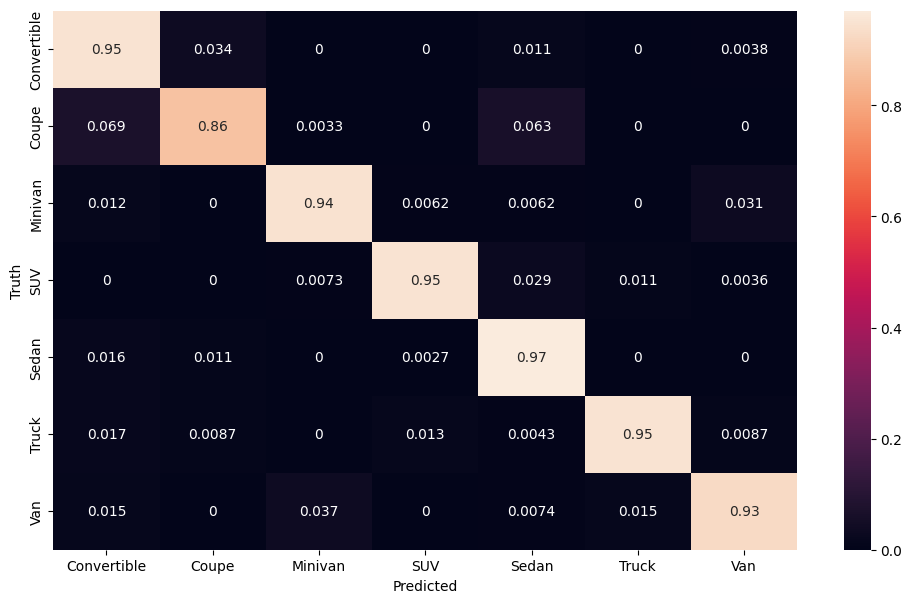

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('cm.png')

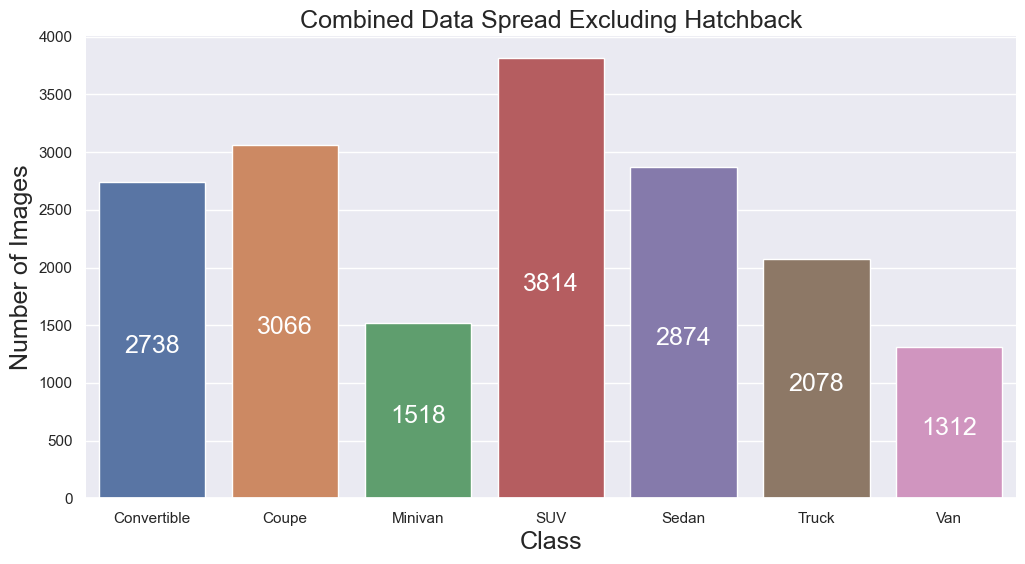

In [ ]:
class_keys = main_folder.classes
class_length_vals = []
for dir in os.listdir(main_dir):
    path = os.path.join((main_dir), dir)
    num_files = len([f for f in os.listdir(path)
                if os.path.isfile(os.path.join(path, f))])
    class_length_vals.append(num_files)

#data = {class_keys[i]: class_length_vals[i] for i in range(len(class_keys))}
data = pd.DataFrame(list(zip(class_keys, class_length_vals)), columns =['Class', 'Number of Images'])

fig, ax = plt.subplots(figsize=(12,6))

sn.set(style="darkgrid")
sn.barplot(data=data, x="Class", y="Number of Images")
plt.xlabel('Class', size=18)
plt.ylabel('Number of Images', size=18)
plt.title('Combined Data Spread Excluding Hatchback', size=18)
plt.xticks(size=11)
plt.yticks(size=11)
for i, val in enumerate(class_length_vals):
    plt.text(x=i, y=(val-100)/2, s=str(val), 
                    color='white', fontsize=18, horizontalalignment='center', verticalalignment='center')

sn.despine();
sn.despine(left=True);
plt.savefig('bargraph.png')


In [ ]:
# import shutil
# for file in os.listdir("./stanford_cars_type_flipped+/Minivan"):
#     if "Van" in file:
#         shutil.move("./stanford_cars_type_flipped+/Minivan/"+file, "./stanford_cars_type_flipped+/Van")

In [61]:
#using model on single image
res_mod.load_state_dict(torch.load("C:/Users/benjamin.guerrieri/Documents/AutoSenseBackup/Models/car_model_TL.pt"))

from torchvision import transforms
#identifies a transformer to make all images the same size
transformer = torchvision.transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomHorizontalFlip(),
    #transforms.Grayscale()
])
img = "C:/Users/benjamin.guerrieri/Documents/AutoSenseBackup/SingleTestImages/Conv.jpg"

# model = ResNet(img_channels=3, num_layers=18, block=BasicBlock, num_classes= len(classes))
# model.load_state_dict(torch.load("./car_model.pt"))
res_mod.eval()
img_normalized = transformer(Image.open(img)).float()
img_normalized = img_normalized[np.newaxis, ...]

# output = model(img_normalized)
# output = torch.argmax(output, 1)
# output
# print(classes[output])


######## probability code


from sklearn.metrics import classification_report
output = res_mod(img_normalized)


def get_probs(output):
    probs = nn.functional.softmax(output,dim=1)
    probs = probs.tolist()
    p = max(probs[0])
    return format(p, '.3f')
    
print(get_probs(output))
# _, predictions = torch.max(output, dim = 1)

# print(classes[predictions])



1.000
